# ARIMA for Modeling Cloud Resource Usage Prediction


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import read_csv, datetime
from pandas.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.linear_model import LassoCV, RidgeCV
from itertools import product                    
from tqdm import tqdm_notebook
import matplotlib.dates as mdates
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pandas import DataFrame

%matplotlib inline

import warnings                                
warnings.filterwarnings('ignore')

## Read in data

In [2]:
base_path = r'../'
data_path = '/home/julian/dataset/'
model_path = base_path+'models/'

In [3]:
path = data_path+'2013-8/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join 
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file)

In [4]:
#path = data_path+'Materna-Trace-2/'                     
#all_files = glob.glob(os.path.join(path, "*.csv"))     
#df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
#concatenated_df8   = pd.concat(df_from_each_file)

In [5]:
#path = data_path+'Materna-Trace-3/'                   
#all_files = glob.glob(os.path.join(path, "*.csv"))  
#df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
#concatenated_df9   = pd.concat(df_from_each_file)

### Create Data Frame

In [6]:
#newdat = concatenated_df.append(concatenated_df8)
#newerdat = newdat.append(concatenated_df9)
#concatenated_df = newerdat
concatenated_df.shape

(11221800, 12)

In [7]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1376314846,4,11703.99824,10912.027692,93.233333,67108864.0,6.129274e+06,0.133333,15981.600000,0.000000,2.133333,1
1,1376315146,4,11703.99824,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,0.000000,2.600000,1
2,1376315446,4,11703.99824,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,535.666667,23.933333,1
3,1376315746,4,11703.99824,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,349.666667,5.466667,1
4,1376316046,4,11703.99824,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,0.000000,2.066667,1


## Feature engineering and converting pandas into a timeseries


In [8]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.apply(pd.to_numeric, errors='ignore')

# Date Feature Engineering
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)

# Other Feature Engineering
#concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
#concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
#concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
#concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]
#concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
#concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

#concatenated_df["write_prev"] = concatenated_df['Disk write throughput [KB/s]'].shift(1)
#concatenated_df["write_diff"] = concatenated_df['Disk write throughput [KB/s]']- concatenated_df["write_prev"]
#concatenated_df["read_prev"] = concatenated_df['Disk read throughput [KB/s]'].shift(1)
#concatenated_df["read_diff"] = concatenated_df['Disk read throughput [KB/s]']- concatenated_df["read_prev"]

### Fill in missing values using forward propagating function from pandas

In [9]:
concatenated_df = concatenated_df.fillna(method='ffill')

### Create new data frame: resampled & aggregated over each hour for all VMs.
This allows to get a broader picture of the network's activity. 
Examine autocorrelations of hourly transmitted, received, and CPU usage

In [10]:
hourlydat = concatenated_df.resample('H').sum()


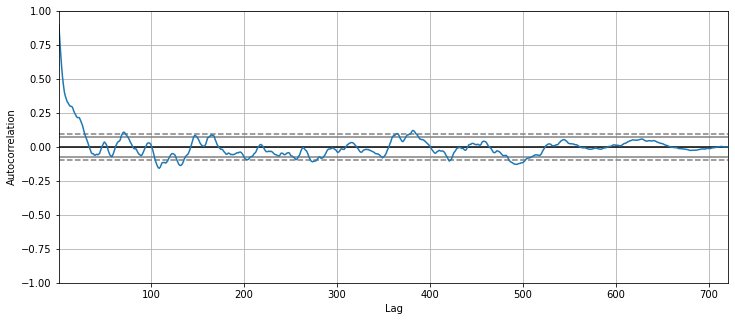

In [11]:
## Hourly resampled means
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(hourlydat['CPU usage [MHZ]']);

#### Is CPU Capacity Ever Met?

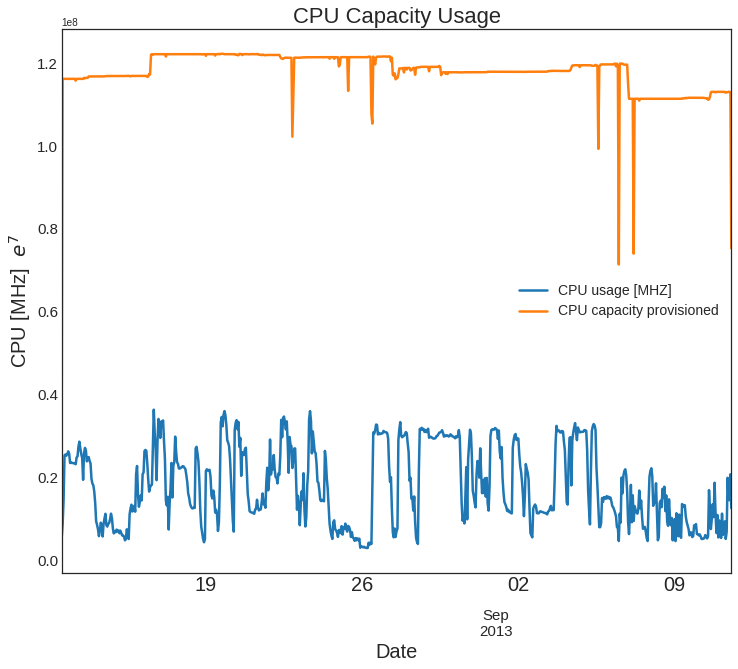

In [12]:
overprovision = pd.DataFrame(hourlydat['CPU usage [MHZ]'])
overprovision['CPU capacity provisioned'] = pd.DataFrame(hourlydat['CPU capacity provisioned [MHZ]'])
#overprovision.to_csv("overprovision.csv", sep = ",")

plt.style.use('seaborn-white')
overprovision.plot(figsize = (12,10),linewidth=2.5,fontsize=20)
plt.title('CPU Capacity Usage',fontsize=22)
plt.ylabel((r'CPU [MHz]  $e^{7}$'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.tick_params(labelsize=15)
plt.xticks( fontsize = 15)
plt.legend(loc="best", fontsize =14)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (1,6))
plt.show()

In [13]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.tick_params(labelsize=20)
    plt.xlabel("Features", fontsize = 20) 
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [15]:
X_train = 1
X_test = 1
def plotModelResults(prediction, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    #prediction = model.predict(X_test)

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "violet", label="Prediction", linewidth=2.0)
    plt.plot(y_test.values,"green", label="Actual Usage", linewidth=2.0)
    #plt.plot(capprv.values, color='red',label = "Actual Provision")

    plt.ylabel("CPU Usage [MHZ]", fontSize=15)
    plt.xlabel("Time", fontSize=15)
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="Upper/Lower Bounds", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        plt.tick_params(labelsize=20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        plt.yticks([2000000,6000000,12000000])# customized for graph readability
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean Absolute Error: {0:.2f}%".format(error),  fontsize = 20)
    plt.legend(loc="best", fontsize = 15)
    plt.tight_layout()
    plt.grid(True);

## ARIMA MODELING

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

## Prepare data for model with features

In [17]:
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]

# Adding the lag of the target variable from 3 steps (hours) up to 24
#for i in range(3, 25):
#    data["lag_{}".format(i)] = data.y.shift(i)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

In [18]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [19]:

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [20]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(504, 0) (217, 0)
(504,) (217,)


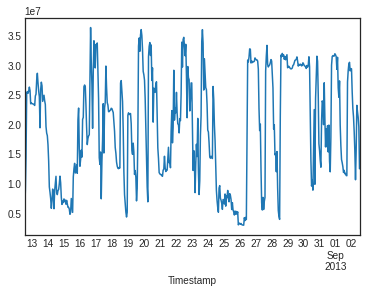

In [21]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
y_train.plot()
pyplot.show()

In [22]:
history = [x for x in y_train]
predictions = list()
for t in range(len(y_test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat[0])
	obs = y_test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 17012191212484.262


In [23]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  719
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11961.541
Method:                       css-mle   S.D. of innovations        4062715.925
Date:                Fri, 24 Apr 2020   AIC                          23937.083
Time:                        01:46:40   BIC                          23969.128
Sample:                             1   HQIC                         23949.455
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.121e+04   1.28e+05      0.166      0.869    -2.3e+05    2.72e+05
ar.L1.D.y      0.0443      0.037      1.193      0.233      -0.028       0.117
ar.L2.D.y     -0.0200      0.037     -0.537      0.5

In [24]:
def plotModelResiduals(model):
    residuals = model.resid
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(residuals, "blue", label="Residuals", linewidth=2.0)
    plt.ylabel("CPU Usage [MHZ]", fontSize=15)
    plt.xlabel("Time", fontSize=15)
    plt.title("ARIMA Residual Errors Line Plot",  fontsize = 20)
    plt.legend(loc="best", fontsize = 15)
    plt.tight_layout()
    plt.grid(True);

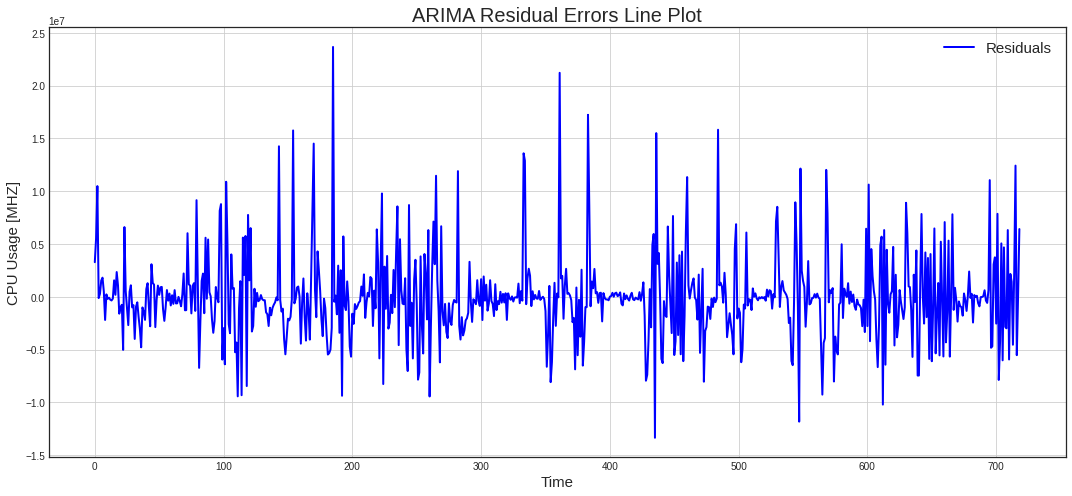

In [25]:
plotModelResiduals(model_fit)

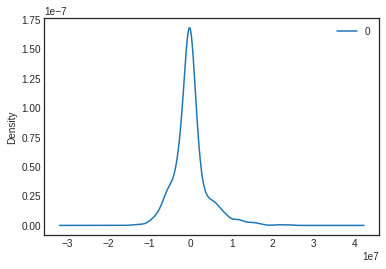

                  0
count  7.190000e+02
mean  -3.512528e+03
std    4.065999e+06
min   -1.334060e+07
25%   -1.894864e+06
50%   -2.596768e+05
75%    1.064731e+06
max    2.366627e+07


In [26]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot(kind='kde')
#sns.kdeplot(residuals)
pyplot.show()
print(residuals.describe())

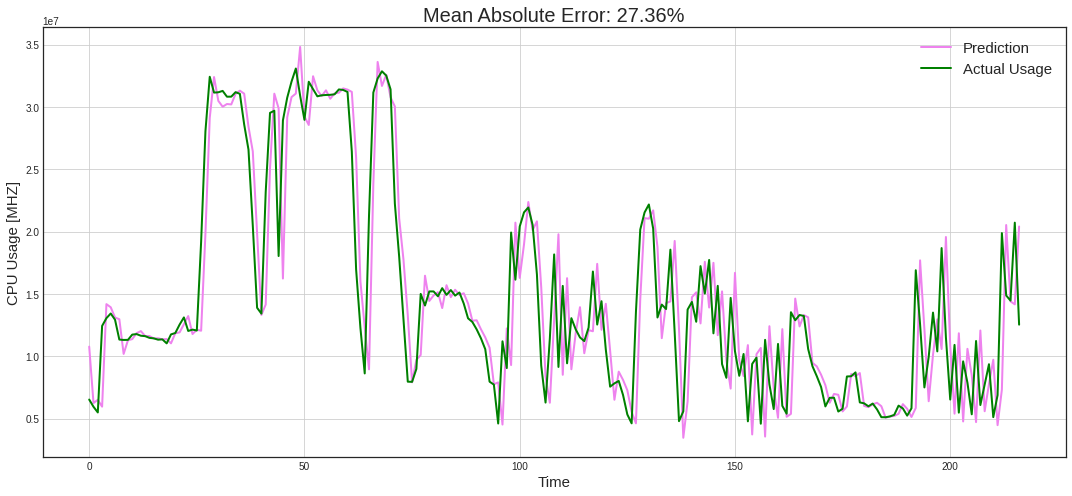

In [27]:
plotModelResults(predictions)

In [28]:
import pickle
filename = model_path+'arima.model'
pickle.dump(model, open(filename, 'wb'))